<a href="https://colab.research.google.com/github/abdalazizrashid/Auger-Electron-Spectroscopy/blob/master/XPS_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob
import os.path as osp
plt.rcParams['axes.grid'] = True

### Reading asc file

In [0]:
class AesSpec:
    def __init__(self, filename):
    
        #assert filename.endswith('.asc')
        with open(filename, mode='r') as f:
            self.spec_range = f.readline()
            self.meta0 = f.readline()
            self.surv = f.readline()
            self.something = int(f.readline())
            self.ev_min = float(f.readline())
            self.ev_step = float(f.readline())
            self.n_points = int(f.readline())
            self.data = np.zeros(self.n_points)
            for i in range(self.n_points):
                self.data[i] = float(f.readline())
        idx = pd.Index(data=np.linspace(
                                    self.ev_min,
                                    self.ev_min + self.n_points*self.ev_step,
                                    self.n_points),
                       name='eV')
        self.ts = pd.Series(self.data,
                            name=os.path.split(filename)[-1],
                            index=idx)

    @staticmethod
    def all_specs():
        return glob.glob('asc/*-aes.asc')

In [0]:
root_path = "/home/master/Notebook/AES_standard/*"
dataset = []
elements = []
lenght = []
for file in glob.glob(root_path):
    try:
        filename = osp.splitext(osp.split(file)[-1])[0]
        specs = AesSpec(file).ts
        y = specs.iloc[:].to_numpy()
        #x = specs.index.to_numpy()
        elements.append(filename)
        dataset.append(y)
        lenght.append(len(y))
    except:
        print("Error Reading file!")
dataset, elements = np.array(dataset), np.array(elements)

711 3191


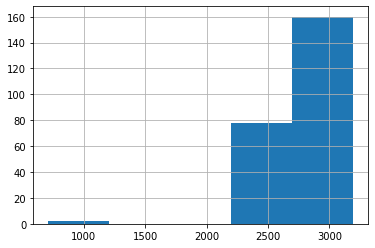

In [4]:
plt.hist(lenght, bins=5)
print(min(lenght), max(lenght))

In [0]:
def smoothdiffS7D7(cnts):
    ''' Create smooth differentiated column from counts using S7D7 PHI algorithm (Multipak tables 
    A-5 and A-1; passing np array (not pandas series)''' 
    numpts=len(cnts)
    endpts=[0,len(cnts)-1] # legacy way of defining endpoints and internal breaks (although those no longer present)
    smooth=[0]*numpts # empty list of correct length for smoothed data
    smoothdiff=[0]*numpts # 7 pt diff of above smoothed data
    # smoothing of endpoints according to Multipak algorithm appendix table A-5    
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list            
        if diff==0:
            if i==numpts-1: #last point
                smooth[i]=(2*cnts[i]+2*cnts[i-1]+1)/4 # additional special case for last point
            else: # first point
                smooth[i]=(2*cnts[i]+2*cnts[i+1]+1)/4 # all others at exact breaks can use value and adj higher value
        elif abs(diff)==1:  # works for +1 or -1 from nearest break
            smooth[i]=(1*cnts[i-1]+2*cnts[i]+1*cnts[i+1]+1)/4
        elif abs(diff)==2:
            smooth[i]=(-3*cnts[i-2]+12*cnts[i-1]+17*cnts[i]+12*cnts[i+1]+-3*cnts[i+2]+1)/35
        else:
            smooth[i]=(-2*cnts[i-3]+3*cnts[i-2]+6*cnts[i-1]+7*cnts[i]+6*cnts[i+1]+3*cnts[i+2]-2*cnts[i+3]+1)/21

    # Same structure to perform differentiation on smoothed datalist above
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list
        if abs(diff)<=2:
            smoothdiff[i]=0  # just zero out endpoints (old code moved to python software dev xls cell)
        else:
            smoothdiff[i]=(-3*smooth[i-3]-2*smooth[i-2]-1*smooth[i-1]+1*smooth[i+1]+2*smooth[i+2]+3*smooth[i+3]+1)/28
    smoothdiff=np.asarray(smoothdiff)
    return smoothdiff

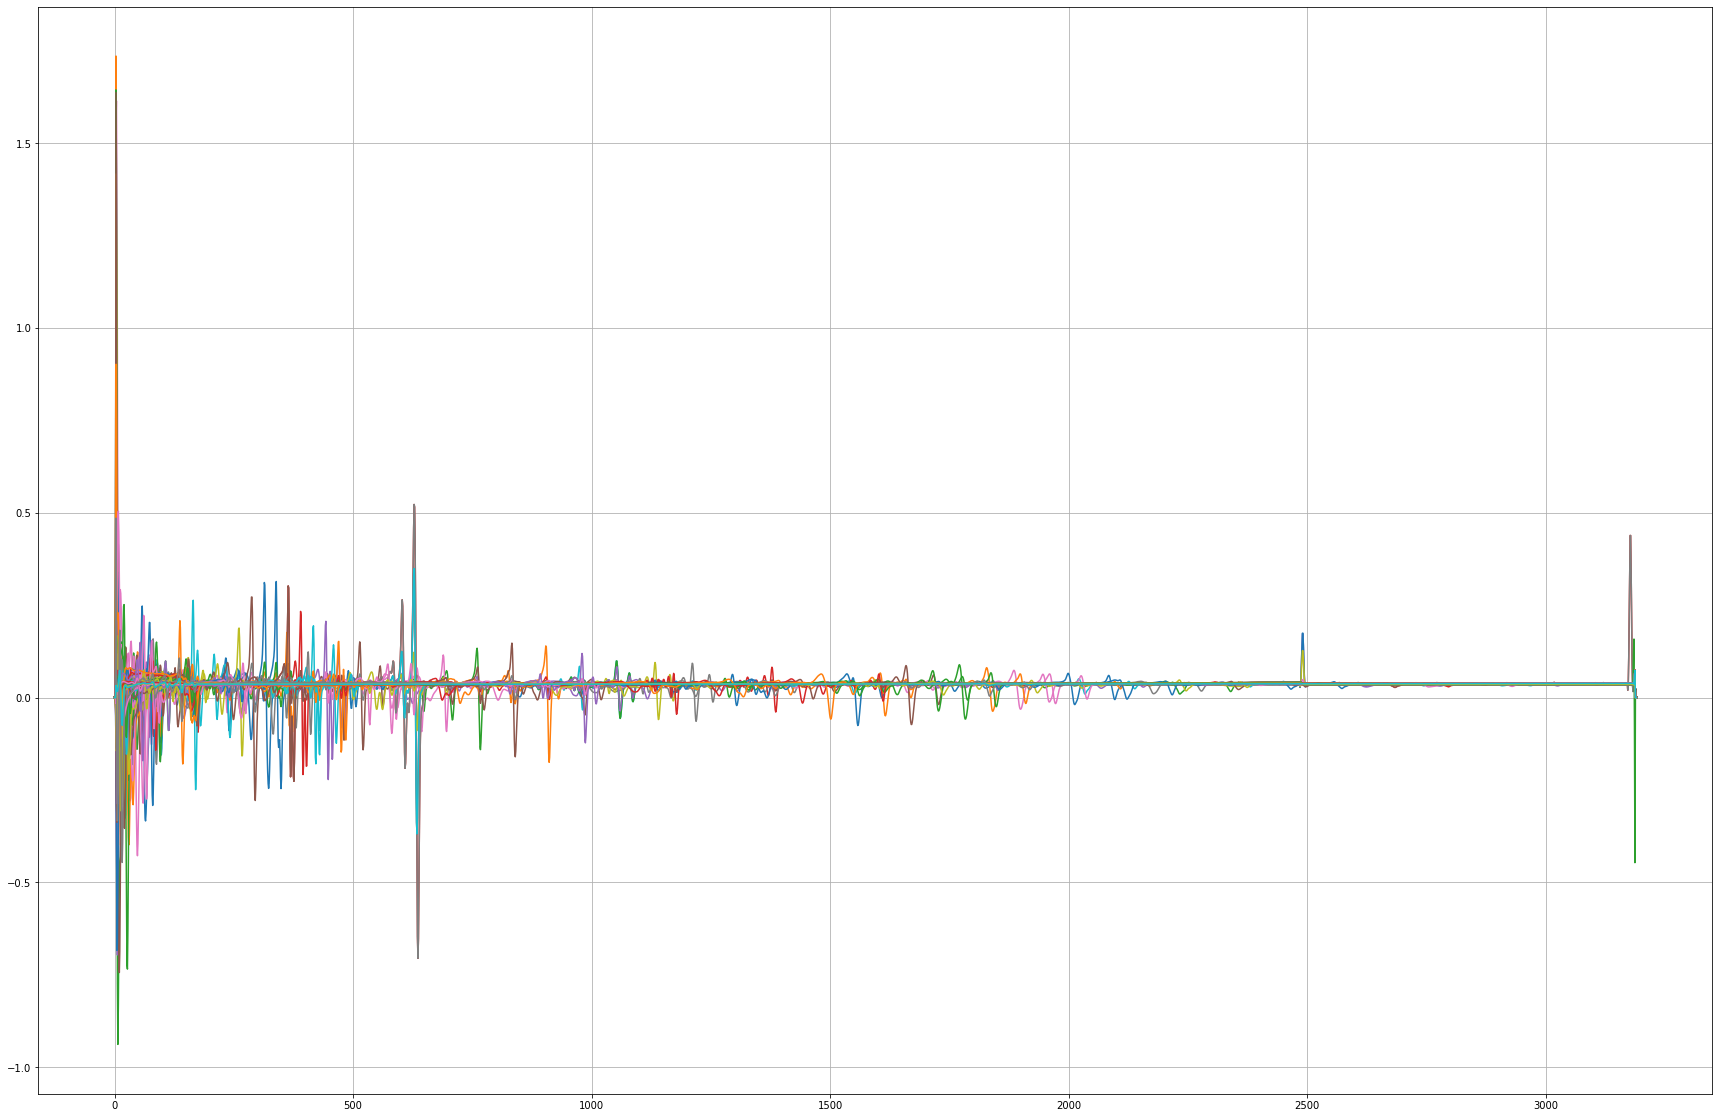

In [6]:
plt.figure(figsize=(30,20))
# Normalize to mean of 0 and standard deviation of 1
def norm(x): return (x-np.mean(x))/np.std(x)

# Normalize to a range between 0, 1
def norm2(x): return (x-np.min(x))/(np.max(x) - np.min(x))

# Padding to respect to the maximum lenght in the dataset
def pad(x):
    shape = ((max(lenght)-len(x)))
    p = np.full(shape, max(x))
    p = np.insert(p, 0, x)
    return p
X = []
Y = []
for i in range(len(dataset)):
    tmp = smoothdiffS7D7(pad(norm(dataset[i])))
   # tmp = pad(norm(dataset[i]))

    plt.plot(tmp)
    Y.append(tmp)
    X.append(np.arange(0, len(tmp)))
#plt.xscale('log')  
#plt.plot(norm(dataset[100]), alpha=0.5, color='r', marker='.')
plt.show()
Y = np.array(Y)
x = np.array(X)

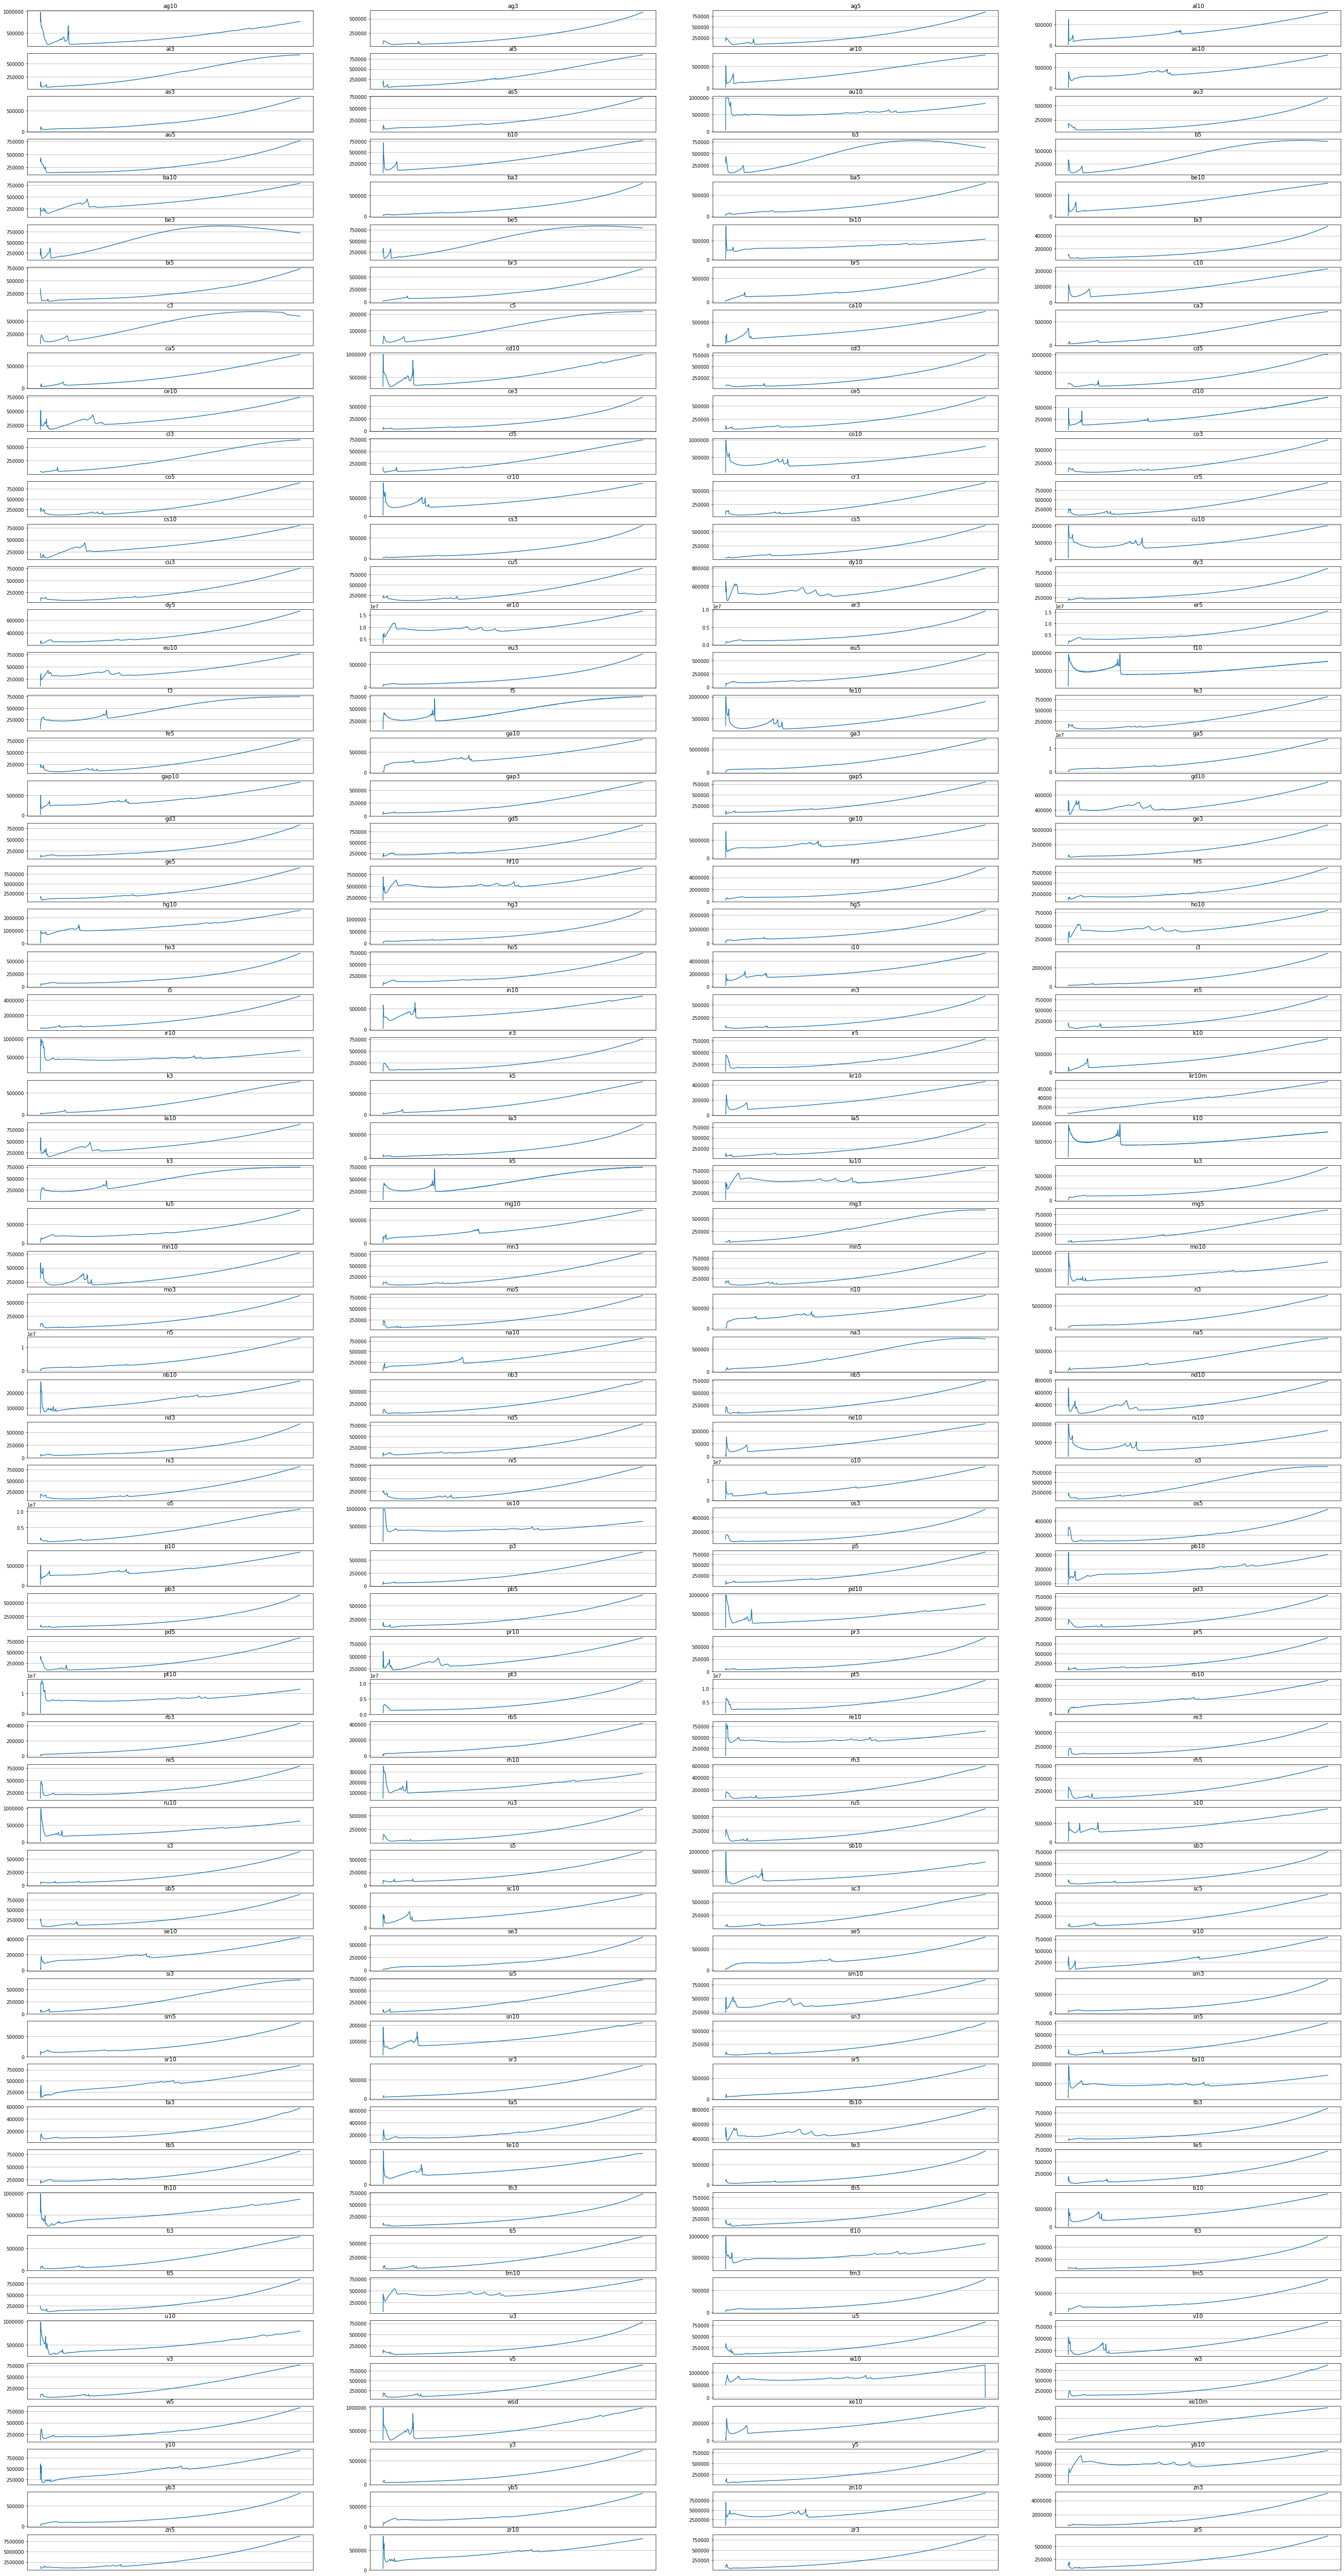

In [7]:
fig, ax = plt.subplots(len(dataset)//4, 4, figsize = (50, 100))
plt.grid(True)
for i in range(len(dataset)):
    ax.flat[i].plot(dataset[i])
    ax.flat[i].set_title(elements[i])
    ax.flat[i].get_xaxis().set_ticks([])
#fig.savefig("AudioWaveform", dpi=900)     

In [0]:
plt.figure(figsize=(30,10))

def mixture(input_array, num_of_samples=3, parameter=1000):
    mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
    _y = np.zeros((3191))
    for i in range(num_of_samples):
        print()
        _y += np.sqrt(np.power(np.random.permutation(mix[i] * input_array[i], ), 2))
    return _y


plt.plot(mixture(Y, num_of_samples=, parameter= 1000),'r')
plt.plot(Y[0], '.')
plt.plot(Y[1], '-')
plt.plot(Y[2], '-')
plt.show()


#   mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
#     _y = np.zeros((3191))
#     for i in range(num_of_samples):
#         print()
#         _y += mix[i] * input_array[i]
#     return _y

SyntaxError: ignored

In [0]:
smth = np.zeros((Y.shape[0], ))
smth1 = np.random.dirichlet(np.ones(3))


In [0]:
plt.plot(smth2)

NameError: name 'smth2' is not defined

In [0]:
plt.figure(figsize=(20, 15))
plt.plot(Y[1])
plt.plot(Y[100])
plt.plot(mixture(Y, 3)[0], color='r')
plt.show()

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda:0')
class Data(Dataset):
   

    def __init__(self, data, name):
                 
        self.data = data
        self.name = name
        assert len(name) == len(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        y = self.data[idx]
        name = self.name[idx]
        s = pd.Series(np.arange(0, 240))
        Name = pd.get_dummies(s).to_numpy()
        cuda = torch.device('cuda:0')

        return (torch.tensor((y)).view(1, 3191), torch.tensor(Name[idx]).float())
    
    

In [9]:
print(str(elements))

['ag10' 'ag3' 'ag5' 'al10' 'al3' 'al5' 'ar10' 'as10' 'as3' 'as5' 'au10'
 'au3' 'au5' 'b10' 'b3' 'b5' 'ba10' 'ba3' 'ba5' 'be10' 'be3' 'be5' 'bi10'
 'bi3' 'bi5' 'br3' 'br5' 'c10' 'c3' 'c5' 'ca10' 'ca3' 'ca5' 'cd10' 'cd3'
 'cd5' 'ce10' 'ce3' 'ce5' 'cl10' 'cl3' 'cl5' 'co10' 'co3' 'co5' 'cr10'
 'cr3' 'cr5' 'cs10' 'cs3' 'cs5' 'cu10' 'cu3' 'cu5' 'dy10' 'dy3' 'dy5'
 'er10' 'er3' 'er5' 'eu10' 'eu3' 'eu5' 'f10' 'f3' 'f5' 'fe10' 'fe3' 'fe5'
 'ga10' 'ga3' 'ga5' 'gap10' 'gap3' 'gap5' 'gd10' 'gd3' 'gd5' 'ge10' 'ge3'
 'ge5' 'hf10' 'hf3' 'hf5' 'hg10' 'hg3' 'hg5' 'ho10' 'ho3' 'ho5' 'i10' 'i3'
 'i5' 'in10' 'in3' 'in5' 'ir10' 'ir3' 'ir5' 'k10' 'k3' 'k5' 'kr10' 'kr10m'
 'la10' 'la3' 'la5' 'li10' 'li3' 'li5' 'lu10' 'lu3' 'lu5' 'mg10' 'mg3'
 'mg5' 'mn10' 'mn3' 'mn5' 'mo10' 'mo3' 'mo5' 'n10' 'n3' 'n5' 'na10' 'na3'
 'na5' 'nb10' 'nb3' 'nb5' 'nd10' 'nd3' 'nd5' 'ne10' 'ni10' 'ni3' 'ni5'
 'o10' 'o3' 'o5' 'os10' 'os3' 'os5' 'p10' 'p3' 'p5' 'pb10' 'pb3' 'pb5'
 'pd10' 'pd3' 'pd5' 'pr10' 'pr3' 'pr5' 'pt10' 'pt3' 'pt

In [10]:
next(iter(Data(Y, elements)))

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [0]:
bs = 240
trainloader = torch.utils.data.DataLoader(Data(Y, elements), batch_size=bs,
                                         shuffle=False, num_workers=4, pin_memory=False)

In [122]:
import pandas as pd
import wandb
import torch


#90dd838e588a5bce5c551a082a1dfdb39dff7487

wandb.init(project="test")


# s = pd.Series(np.arange(1, 118))
# y = pd.get_dummies(s).to_numpy()
# _y = np.arange(0, 118)
# X = torch.tensor(Y.reshape(1, 3191, -1)).float()
# y = torch.tensor(_y.reshape(1, 118)).float()
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=11, stride=1)
        self.conv2 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=21, stride=1, padding=5)
        self.conv3= torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=41, stride=1, padding=15)
        self.conv4= torch.nn.Conv1d(in_channels=384, out_channels=512, kernel_size=5, stride=1)### in_channels=384
        self.avg5= torch.nn.AdaptiveAvgPool1d(1)
        self.sigmoid= torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        def relu(x): return x.clamp(0.) - 0.5
        

        self.flatten= torch.nn.Flatten()
        
        # dense layer has 4*512 input dim
        # Contamination
        self.dropout= torch.nn.Dropout(p=0.2)
        self.co_dense1= torch.nn.Linear(in_features=512, out_features=100)
        self.co_dense2= torch.nn.Linear(in_features=100, out_features=1)
        
        # Quantification
        
        self.qu_dense1= torch.nn.Linear(in_features=513, out_features=513)
        self.qu_dense2= torch.nn.Linear(in_features=513, out_features=240+1)
        #self.norm= torch.nn.BatchNorm1d(num_features=81)
        
    def forward(self, x):
        f_1_1 = self.relu(self.conv1(x))
        f_1_2 = self.relu(self.conv2(x))
        f_1_3 = self.relu(self.conv3(x))


        t = torch.cat((f_1_1, f_1_2, f_1_3), dim=1)


        f_2 = self.conv4(t)
        f_2 = self.avg5(f_2)
        f_2 = self.flatten(f_2)

        #f_3 = self.dropout(f_2)
        f_3 = self.co_dense1(f_2)
        f_3 = self.relu(f_3)
        f_3 = self.co_dense2(f_3)
        

        
        # f_4 = self.dropout(torch.cat((f_3, f_2), dim=1))
        f_4 = torch.cat((f_3, f_2), dim=1)
        f_4 = self.qu_dense1(f_4)
        f_4 = self.relu(f_4)
        f_4 = self.qu_dense2(f_4)
 #       f_4 = self.relu(f_4)
        
        


        return f_4[...,:-1], f_4[...,-1]
    
    



wandb: Wandb version 0.8.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [123]:
cuda = torch.device('cuda:0')

model = Simple1DCNN().to(cuda)
def cross_entropy_one_hot(input, target):
    labels = target.max(dim=1)[1]
    return torch.nn.CrossEntropyLoss()(input, labels)
wandb.watch(model)

In [0]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
import torch.distributions.relaxed_categorical

In [0]:
class DickLoss(torch.nn.Module):
  def forward(self, input, temp, target):
    # target = torch.distributions.utils.clamp_probs(target)
    # temp = torch.full_like(temp, 1e-1)
    # dist = torch.distributions.relaxed_categorical.ExpRelaxedCategorical(temp.unsqueeze(-1), logits=input)
    # return -dist.log_prob(target).mean()
    target = target.argmax(-1)
    print(target.shape)
    return torch.nn.CrossEntropyLoss()(
        input, target
    )

In [0]:
dirloss = DickLoss()

In [128]:
p = torch.rand(3, 240)
p /= p.sum(-1, keepdim=True)
dirloss(p, torch.ones(3), p)

torch.Size([3])


tensor(5.4762)

In [0]:
# from tensorboardX import SummaryWriter

# writer = SummaryWriter()

loss_fn = dirloss #cross_entropy_one_hot
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_size = 4*len(trainloader)
clr = cyclical_lr(step_size)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

import tqdm

In [0]:
def accuracy(out, yb): return (torch.argmax(out, dim=1) == torch.argmax(yb, dim=1)).float().mean()

In [136]:
next(iter(trainloader))[1]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [0]:
#wandb.config.update(args)
def update_log(log):
  wandb.log(log)

def train(epoch=100000, trainloader=trainloader):
  cuda = torch.device('cuda:0')

  log = {"epoch": [], "loss": [], "acc": []}
  with tqdm.tqdm(range(epoch)) as _epochs:
    for epoch in _epochs:
        lr = 0
        for i , data in enumerate(trainloader, 0):
            # Forward pass: compute predicted y by passing x to the model.
            x, y = data; 
            x = x.to(cuda)
            y = y.to(cuda)
            
          
            y_pred, t_pred = model(x.float())
            

            
            # Compute and print loss.
            loss = loss_fn(y_pred, t_pred, y)

            log["acc"] = acc = accuracy(y_pred, y).item() 

            log["loss"] = loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
      
            _epochs.set_description(f"epoch={epoch} acc={acc} loss={loss:.4f}")
        log["epoch"] = epoch
        update_log(log)



In [0]:
train()


  0%|          | 0/100000 [00:00<?, ?it/s]

torch.Size([240])


epoch=0 acc=0.008333333767950535 loss=5.4752:   0%|          | 0/100000 [00:01<?, ?it/s]wandb: Wandb version 0.8.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
epoch=0 acc=0.008333333767950535 loss=5.4752:   0%|          | 1/100000 [00:02<63:02:47,  2.27s/it]

torch.Size([240])


epoch=1 acc=0.004166666883975267 loss=5.8171:   0%|          | 2/100000 [00:04<58:34:26,  2.11s/it]

torch.Size([240])


epoch=2 acc=0.004166666883975267 loss=5.4858:   0%|          | 3/100000 [00:05<50:16:05,  1.81s/it]

torch.Size([240])


epoch=3 acc=0.004166666883975267 loss=5.5513:   0%|          | 4/100000 [00:06<44:31:09,  1.60s/it]

torch.Size([240])


epoch=4 acc=0.004166666883975267 loss=5.5167:   0%|          | 5/100000 [00:07<40:25:36,  1.46s/it]

torch.Size([240])


epoch=5 acc=0.004166666883975267 loss=5.4806:   0%|          | 6/100000 [00:08<37:25:51,  1.35s/it]

torch.Size([240])


epoch=6 acc=0.004166666883975267 loss=5.4868:   0%|          | 7/100000 [00:09<37:34:37,  1.35s/it]

torch.Size([240])


epoch=7 acc=0.004166666883975267 loss=5.4851:   0%|          | 8/100000 [00:11<42:36:37,  1.53s/it]

torch.Size([240])


epoch=8 acc=0.008333333767950535 loss=5.4762:   0%|          | 9/100000 [00:14<52:14:17,  1.88s/it]

torch.Size([240])


epoch=9 acc=0.004166666883975267 loss=5.4754:   0%|          | 10/100000 [00:16<56:17:20,  2.03s/it]

torch.Size([240])


epoch=10 acc=0.004166666883975267 loss=5.4757:   0%|          | 11/100000 [00:17<48:41:37,  1.75s/it]

torch.Size([240])


epoch=11 acc=0.004166666883975267 loss=5.4725:   0%|          | 12/100000 [00:19<49:17:05,  1.77s/it]

torch.Size([240])


epoch=12 acc=0.008333333767950535 loss=5.4681:   0%|          | 13/100000 [00:21<52:44:22,  1.90s/it]

torch.Size([240])


epoch=13 acc=0.004166666883975267 loss=5.4662:   0%|          | 14/100000 [00:23<50:52:51,  1.83s/it]

torch.Size([240])


epoch=14 acc=0.01250000111758709 loss=5.4599:   0%|          | 15/100000 [00:26<55:30:15,  2.00s/it]

torch.Size([240])


epoch=15 acc=0.008333333767950535 loss=5.4507:   0%|          | 16/100000 [00:27<48:11:50,  1.74s/it]

torch.Size([240])


epoch=16 acc=0.01250000111758709 loss=5.4408:   0%|          | 17/100000 [00:29<53:08:24,  1.91s/it]

torch.Size([240])


epoch=17 acc=0.008333333767950535 loss=5.4242:   0%|          | 18/100000 [00:30<46:33:02,  1.68s/it]

torch.Size([240])


epoch=18 acc=0.008333333767950535 loss=5.4052:   0%|          | 19/100000 [00:32<48:52:22,  1.76s/it]

torch.Size([240])


epoch=19 acc=0.01250000111758709 loss=5.3788:   0%|          | 20/100000 [00:34<46:36:48,  1.68s/it]

torch.Size([240])


epoch=20 acc=0.008333333767950535 loss=5.3443:   0%|          | 21/100000 [00:36<52:24:10,  1.89s/it]

torch.Size([240])


epoch=21 acc=0.01250000111758709 loss=5.3164:   0%|          | 22/100000 [00:38<54:29:50,  1.96s/it]

torch.Size([240])


epoch=22 acc=0.004166666883975267 loss=5.4348:   0%|          | 23/100000 [00:39<47:41:04,  1.72s/it]

torch.Size([240])


epoch=23 acc=0.01250000111758709 loss=5.5745:   0%|          | 24/100000 [00:41<46:07:01,  1.66s/it]

torch.Size([240])


epoch=24 acc=0.01250000111758709 loss=5.3827:   0%|          | 25/100000 [00:43<47:42:52,  1.72s/it]

torch.Size([240])


epoch=25 acc=0.004166666883975267 loss=5.2997:   0%|          | 26/100000 [00:45<49:35:00,  1.79s/it]

torch.Size([240])


epoch=26 acc=0.004166666883975267 loss=5.3095:   0%|          | 27/100000 [00:47<56:05:03,  2.02s/it]

torch.Size([240])


epoch=27 acc=0.01250000111758709 loss=5.1988:   0%|          | 28/100000 [00:49<59:25:43,  2.14s/it]

torch.Size([240])


epoch=28 acc=0.008333333767950535 loss=5.2719:   0%|          | 29/100000 [00:51<57:56:57,  2.09s/it]

torch.Size([240])


epoch=29 acc=0.01250000111758709 loss=5.1474:   0%|          | 30/100000 [00:53<50:26:33,  1.82s/it]

torch.Size([240])


epoch=30 acc=0.004166666883975267 loss=5.2775:   0%|          | 31/100000 [00:54<50:05:12,  1.80s/it]

torch.Size([240])


epoch=31 acc=0.02500000223517418 loss=5.0962:   0%|          | 32/100000 [00:56<44:52:09,  1.62s/it]

torch.Size([240])


epoch=32 acc=0.008333333767950535 loss=5.1657:   0%|          | 33/100000 [00:57<42:51:07,  1.54s/it]

torch.Size([240])


epoch=33 acc=0.01250000111758709 loss=5.0787:   0%|          | 34/100000 [00:58<40:57:44,  1.48s/it]

torch.Size([240])


epoch=34 acc=0.004166666883975267 loss=5.1200:   0%|          | 35/100000 [01:00<41:16:57,  1.49s/it]

torch.Size([240])


epoch=35 acc=0.008333333767950535 loss=5.0022:   0%|          | 36/100000 [01:01<38:58:30,  1.40s/it]

torch.Size([240])


epoch=36 acc=0.02083333395421505 loss=5.0107:   0%|          | 37/100000 [01:03<45:15:08,  1.63s/it]

torch.Size([240])


epoch=37 acc=0.008333333767950535 loss=4.9418:   0%|          | 38/100000 [01:04<41:29:30,  1.49s/it]

torch.Size([240])


epoch=38 acc=0.004166666883975267 loss=5.0190:   0%|          | 39/100000 [01:05<38:38:52,  1.39s/it]

torch.Size([240])


epoch=39 acc=0.02916666865348816 loss=4.9400:   0%|          | 40/100000 [01:07<36:51:43,  1.33s/it]

torch.Size([240])


epoch=40 acc=0.03333333507180214 loss=4.9208:   0%|          | 41/100000 [01:08<35:36:32,  1.28s/it]

torch.Size([240])


epoch=41 acc=0.004166666883975267 loss=4.8701:   0%|          | 42/100000 [01:10<45:31:11,  1.64s/it]

torch.Size([240])


epoch=42 acc=0.01250000111758709 loss=4.7947:   0%|          | 43/100000 [01:13<51:37:51,  1.86s/it]

torch.Size([240])


epoch=43 acc=0.03750000149011612 loss=4.7842:   0%|          | 44/100000 [01:14<46:10:55,  1.66s/it]

torch.Size([240])


epoch=44 acc=0.02500000223517418 loss=4.7119:   0%|          | 45/100000 [01:15<42:16:17,  1.52s/it]

torch.Size([240])


epoch=45 acc=0.004166666883975267 loss=4.8345:   0%|          | 46/100000 [01:16<39:27:56,  1.42s/it]

torch.Size([240])


epoch=46 acc=0.02500000223517418 loss=4.9178:   0%|          | 47/100000 [01:17<37:21:46,  1.35s/it]

torch.Size([240])


epoch=47 acc=0.03750000149011612 loss=4.7086:   0%|          | 48/100000 [01:19<35:57:46,  1.30s/it]

torch.Size([240])


epoch=48 acc=0.004166666883975267 loss=5.1525:   0%|          | 49/100000 [01:21<43:11:35,  1.56s/it]

torch.Size([240])


epoch=49 acc=0.03333333507180214 loss=4.7813:   0%|          | 50/100000 [01:23<46:44:03,  1.68s/it]

torch.Size([240])


epoch=50 acc=0.02083333395421505 loss=4.9474:   0%|          | 51/100000 [01:25<54:34:23,  1.97s/it]

torch.Size([240])


epoch=51 acc=0.02916666865348816 loss=4.5738:   0%|          | 52/100000 [01:27<48:47:58,  1.76s/it]

torch.Size([240])


epoch=52 acc=0.004166666883975267 loss=4.9618:   0%|          | 53/100000 [01:28<45:46:25,  1.65s/it]

torch.Size([240])


epoch=53 acc=0.02083333395421505 loss=4.5482:   0%|          | 54/100000 [01:29<42:11:20,  1.52s/it]

torch.Size([240])


epoch=54 acc=0.02500000223517418 loss=4.6956:   0%|          | 55/100000 [01:31<46:15:57,  1.67s/it]

torch.Size([240])


epoch=55 acc=0.02916666865348816 loss=4.6358:   0%|          | 56/100000 [01:33<49:56:17,  1.80s/it]

torch.Size([240])


epoch=56 acc=0.02500000223517418 loss=4.5146:   0%|          | 57/100000 [01:35<50:55:57,  1.83s/it]

torch.Size([240])


epoch=57 acc=0.008333333767950535 loss=4.6509:   0%|          | 58/100000 [01:37<45:35:21,  1.64s/it]

In [0]:
torch.argmax(y_pred, dim=1) == y.T[:16]
#print(torch.argmax(y_pred, dim=1))
y.T[:1]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')

In [0]:
wandb.save("mymodel.h5")


wandb: Wandb version 0.8.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[]

In [0]:
m = torch.nn.AdaptiveAvgPool1d(100)
input = torch.randn(1, 64, 8)
output = m(input)
output.shape

torch.Size([1, 64, 100])

In [0]:
for i , data in enumerate(trainloader, 0):
    data

In [0]:
x, y, d = data
d[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [0]:
d[2].shape

torch.Size([1, 240])

In [0]:
x[0][-1].shape

torch.Size([1])

In [0]:
y_pred.shape

torch.Size([4, 240, 1])